# Filtrado colaborativo

El filtrado colaborativo es una familia de aproximaciones algorítmicas basadas en el comportamiento colaborativo y collectivo. Esto permite realizar una definición a futuro de posibles feedback esperado bajo la matríz de ratings. Podemos encontrar filtrados basados en la similitud entre usuarios (User Based Collaborative Filtering) o basado en ítems (Item Based Colaborative Filtering).

Tras haber explorado la forma en la que podemos trabajar con la matriz de relación ítem-usuario, veremos formas nuevas en las que los avances en el dominio de los modelos de aprendizaje automático nos permiten realizar aproximaciones más precisas a la imputación y estimación de valoraciones (predicciones de feedback de un usuario ante un ítem no consumido).

## Conjunto de datos: Movielens

In [ ]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve

# Dataset
urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
info = zip_ref.read('ml-100k/u.info')

# Users
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

# Movies
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Obtenemos el año de la fecha de publicación
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

# Ratings
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# User-item matrix
user_item_m = ratings.pivot('user_id','movie_id','rating')

Uno de los problemas principales a los que nos enfrentábamos era a la escasez de información habitual debido a que pocos usuarios son los generadores en muchas plataformas de la mayoría de la actividad. Esto se refleja en los vacios que encontramos en la matriz de ratings.

In [ ]:
user_item_m

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Debemos encontrar una forma coherente de rellenar esos huecos y de este modo podremos disponer de las futuras puntuaciones que un usuario dado podría darle a un ítem. Esta información se vuelve extremadamente válida ya que únicamente deberemos mostrar los elementos no consumidos susceptibles de recibir una buena puntuación, pero ¿cómo podemos realizar esta imputación?

# Factorización de matrices

La factorización de matrices permite descomponer una matriz en matrices características de forma que nuestra matriz de recomendaciones ($M \in \mathbb{R}^{m \times n}$) con pares de usuarios e items pueda descomponerse en el producto de dos matrizes:

*   La matriz $U \in \mathbb{R}^{m \times d}$ que representa a nuestros usuarios
*   La matriz $I \in \mathbb{R}^{n \times d}$ que representa a nuestros usuarios

Las representaciones ($U$ e $I$) no son establecidas por nosotros si no que se aplican medios de aprendizaje automático de modo que estas matrices representen de la mejor forma posible la relación $UI^T = M$. De este modo nuestra función objetivo será representada de modo que:

$\min \sum_{i,j} (M_{ij}-U_{ij}V_{ij})^2$

Existen varios medios por los que podemos obtener estas matrices pero sin duda una de las más conocidas tras el concurso de Netflix es la descomposición en valores singlures (SVD). Podeis leer el relato de [Simon Funk](https://sifter.org/~simon/journal/20061211.html) para haceros eco de su trabajo durante este concurso.

## Singular Value Decomposition

La descomposición en valores singulares (o SVD de sus siglas en inglés) descompone nuestra matriz en *vectores y valores singulares*. Expresado de forma sencilla, SVD comprende un funcionamiento similar al del análisis de componentes principales (PCA) con el que quizás estéis más familiarizados. Haremos un ejemplo sencillo donde emplearemos una matriz de muestra.


In [ ]:
A = np.array([[1, 2], [3, 4], [5, np.nan]])
A

array([[ 1.,  2.],
       [ 3.,  4.],
       [ 5., nan]])

Haciendo un simil a nuestro contexto, se trata de una base de conocimiento de tres usuarios y dos items donde solo falta una puntuación por conocer. Deberemos imputar nuestros valores faltantes con un valor aproximado.

In [ ]:
# Imputamos ceros
zeros = [0, 0]
# Los valores faltantes
nans = ~np.isnan(A)
# Y los imputamos
A_h = np.where(nans, A, zeros)
A_h

array([[1., 2.],
       [3., 4.],
       [5., 0.]])

In [ ]:
import scipy

U, s, VT = scipy.linalg.svd(A_h)

In [ ]:
U

array([[-0.28624663, -0.35272096, -0.89087081],
       [-0.7027544 , -0.55472836,  0.4454354 ],
       [-0.65130571,  0.75356776, -0.08908708]])

In [ ]:
s

array([6.58653021, 3.40846297])

In [ ]:
VT

array([[-0.85796894, -0.51370156],
       [ 0.51370156, -0.85796894]])

In [ ]:
Sigma = np.zeros((A.shape[0], A.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:A.shape[1], :A.shape[1]] = np.diag(s)
# reconstruct matrix
U.dot(Sigma.dot(VT))

array([[ 1.00000000e+00,  2.00000000e+00],
       [ 3.00000000e+00,  4.00000000e+00],
       [ 5.00000000e+00, -1.40621636e-16]])

si nos fijamos en detalle veremos que no es exactamente cero lo que devuelve en el valor faltante si no que lo aproxima al valor lógico a obtener como el producto de las dos matrices de representaciones de usuarios y películas. Este es un caso sencillo pero este es el efecto que buscamos a la hora de separar la matriz en componentes, encontrar las mejores representaciones de nuestros usuarios y películas mediante [espacios latentes](https://en.wikipedia.org/wiki/Latent_space) y poder así reconstruir una matriz confiable de puntuaciones.

Aquellos que queráis ahondar en como funciona este proceso podéis recurrir a este [tutorial del MIT](http://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm) que os guiará en el proceso paso a paso. Nosotros nos beneficiaremos del trabajo previamente realizado por otros de forma que podamos explotar las librerías existentes. Un recurso muy válido en este sentido será la librería [Surprise](http://surpriselib.com/).

## Surprise

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633695 sha256=251ddb50f7811f2a1c41f6ebc1ce65424cd9d293a2f57ff853fe6a5145aca58f
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
from surprise import Reader
from surprise import Dataset

# Definimos un reader para indicar la escala de los ratings
reader = Reader(rating_scale=(1, 5))

# Y damos formato a los datos tal y como la librería los espera
df = ratings[['user_id', 'movie_id', 'rating']]
df = df.rename(columns={"rating": "raw_ratings"})
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'raw_ratings']], reader)

Podemos de forma sencilla gracias a la librería Surprise importar, por ejemplo, nuestro anterior ejemplo basado en memoria donde emplearemos modelos como el de los vecinos cercanos. Podremos variar la métrica de similitud entre varias de [las disponibles y más comunes](https://surprise.readthedocs.io/en/stable/similarities.html#module-surprise.similarities).

En nuestro caso, y por variar, emplearemos la correlación de [Pearson](https://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson).

In [ ]:
from surprise import KNNBasic

# Indicamos como opción de similitud la correlación de pearson
sim_options = {'name': 'pearson_baseline'}
algo = KNNBasic(sim_options=sim_options)

# Y entrenamos nuestro modelo
model = algo.fit(data.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
knn_pred = model.predict(uid=195, iid=55)

Disponemos de multitud de modelos, entre ellos [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD). En este caso además emplearemos técnicas de validación cruzada para poder así conocer el nivel de precisión de nuestro modelo.

### Ejercicio

In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate

"""
Ejercicio: Explorar en la documentación de Surprise para encontrar como se deben indicar que
el algorimo a ejecutar es SVD
"""

# Importamos nuestro algoritmo
algo =  SVD()

# Y utilizaremos una validación cruzada de 5-plieges (5-fold)
validation = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9482  0.9292  0.9311  0.9398  0.9363  0.9369  0.0068  
MAE (testset)     0.7446  0.7330  0.7325  0.7418  0.7384  0.7380  0.0048  
Fit time          7.12    10.07   9.02    5.46    4.07    7.15    2.21    
Test time         0.22    0.47    0.23    0.19    0.21    0.26    0.10    


Es importante que garanticemos un rendimiento previo a entrenar nuestro modelo de cara a entender cual es la precisión esperada que podemos obtener en nuestro sistema.

In [ ]:
model = algo.fit(data.build_full_trainset())

Gracias a este modelo podemos predecir los rating que establecería un usuario sobre nuestro conjunto de datos. Por ejemplo, el usuario 196 sobre la película 55.

In [ ]:
svd_pred = model.predict(uid=195, iid=55)

In [ ]:
print(f'KNN rating prediction for movie 55 and user 195: {knn_pred.est}')
print(f'SVD rating prediction for movie 55 and user 195: {svd_pred.est}')

KNN rating prediction for movie 55 and user 195: 3.7314194450611016
SVD rating prediction for movie 55 and user 195: 3.5779895940549613


Vemos que la valoración difiere ligeramente. Por ello es importante cerciorarse de la bondad del modelo así como de disponer de suficiente disparidad a la hora de emplear sistemas híbridos como veremos en la última sección de este *notebook*. Podéis probar a variar las opciones del algoritmo a emplear y contrastar si existen diferencias entre las distintas opciones en la librería Surprise para [Factorización de matrices](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#)

A continuación emplearemos estos métodos para recomendar los ítems con mejor valoración potencial de las no vistas por el usuario sujeto de la recomendación. Nuestro sistema de generación por tanto será las películas no vistas y el sistema de puntuación será la predicción del modelo entrenado SVD.

### Ejercicio

Tengo duda si esta bien con nan_cols[1]

In [ ]:
def svd_recommender(user_id, umbral=4.5):

  """
  Ejercicio: Buscaremos los elementos no consumidos por el usuario 
  y filtraremos aquellos por encima del umbral como a recomendar usando el modelo
  SVD previamente entrenado
  """
  # Items sin puntuación (no vistos o evaluados)
  nan_cols = [i for i in user_item_m.columns if np.isnan(user_item_m.loc[user_id][i])]

  # Generamos una valoración para cada uno de ellos
  candidatos =model.predict(uid=user_id, iid=1)

  rec_df = movies[movies["movie_id"].isin(candidatos)][["movie_id","title"]]
  return rec_df


In [ ]:
svd_recommender(5, umbral=4.2)

,movie_id,title
0,1,Toy Story (1995)
4,5,Copycat (1995)


In [ ]:
svd_recommender(196, umbral=4.4)

,movie_id,title
0,1,Toy Story (1995)
195,196,Dead Poets Society (1989)


Estos ratings son calculados en base a la representación de nuestro usuario y nuestros items con lo que cierta infromación relativa al contexto puede que sea obviada y aunque estadísticamente tenga todo el sentido del mundo, los generos más visitados, actores preferidos,... son cuestiones que puede interesar incluir en nuestros recomendadores.

Por ese motivo se ha puesto mucho esfuerzo en la codificación de la información que caracteriza a los usuarios y las películas en los sistemas más recientes. Además, con el auge de las redes neuronales profundas, podemos beneficiarnos de los desarrollos recientes para englobar todo nuestro conocimiento en las distintas capas que compongan nuestra red.

# Modelos basados en redes neuronales

Sin duda las redes neuronales han supuesto una revolución en el aprendizaje automático y la capacidad de abstracción de los sistemas. Siendo Tensorflow uno de los frameworks más empleados en este ámbito, se hicieron eco de est uso y por ello disponemos de recursos para poder de forma sencilla emplear estos recursos en nuestros sistemas de recomendación gracias a [TensorFlow Recommenders](https://www.tensorflow.org/recommenders).

Estos modelados pueden resultar complejos y parten de un conocimiento técnico importante por lo que, para simplificar nuestro ejerccio emplearemos una aproximación basada en Keras pero aquellos que os dispongáis de los conocimientos necesarios no dudéis en explorar la vía de Tensorflow.

Estas técnicas se basan en la construcción de modelos de abstracción de usuarios basado en redes neuronales que convergen las características base de los usuarios y los items a una representación (o embeding). Esto nos permite construir una reducción en la complejidad de los usuarios e items de forma que para conjuntos muy voluminosos de datos únicamente con su representación podremos generar un número acotado de muestras entre las que poder realizar el ejercicio de recomendación manteniendo la confianza en los resultados.

![twotower](https://1.bp.blogspot.com/-ww8cKT3nIb8/X2pdWAWWNmI/AAAAAAAADl8/pkeFRxizkXYbDGbOcaAnZkorjEuqtrabgCLcBGAsYHQ/s0/TF%2BRecommenders%2B06.gif)

El primer ejercicio será el de disponer toda la información necesaria para que la red pueda ser entrenada. Además separaremos en conjunto de entrenamiento (90%) y conjunto de validación (10%) nuestro conjunto de datos.

In [ ]:
# Copiamos nuestro conjunto de datos de puntuaciones
df = ratings

# Codificamos los identificadores de usuarios
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
num_users = len(ratings["user_id"].unique())

# Codificamos los identificadores de los items
movie_ids = df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
num_movies = len(ratings["movie_id"].unique())

# Y los incorporamos al conjunto de datos
df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["movie_id"].map(movie2movie_encoded)

In [ ]:
# Rango de valores para los ratings
min_rating = 1.0
max_rating = 5.0

# Datos de entrada para nuestra red
x = df[["user", "movie"]].values

# Normalizamoz los ratings entre 0 y 1
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Realizamos la separación entre entrenamiento y validación
idx = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

Con esto podremos plantear nuestra clase base que se encargará de gestionar el modelo y ser invocado durante el proceso de entrenamiento.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(keras.Model):
    """
    Clase que codifica un modelo tipo como red de recomendación
    """
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        # Tamaño de nuestros modelos de representación (embeding)
        self.num_users = num_users
        self.num_movies = num_movies

        # Representación de usuarios
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1) # Bias

        # Representación de ítems
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1) # Bias

    # Funcion que se invoca con una entrada tipo
    def call(self, inputs):
        # Usuario
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        # Item
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        # Vector de entrada para la red (user + item + bias)
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias

        # Aplicamos una función sigmoidea para evaluar el rating (0 a 1.0)
        return tf.nn.sigmoid(x)

Con nuestra estructura neuronal planteada simplemente deberemos instanciar el modelo indicando cual serán las funciones de pérdida (losses) y el optimizador a emplear cuando entrenemos la red.

Seleccionaremos [BinaryCrossEntropy](https://keras.io/api/losses/probabilistic_losses/) como función que evaluará la bondad de nuestro modelo; y [Adam](https://keras.io/api/optimizers/adam/) como función de optimizador en nuestro ejercicio pero estos parámetros pueden variarse siempre teniendo en cuenta las características de nuestro problema a resolver.

In [ ]:
model = RecommenderNet(num_users, num_movies)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001))

Habiendo definido nuestro modelo, solo resta ajustarlo en base a nuestro conjunto de datos.

In [ ]:
batch_size = 64 # Numero de muestras por lote a emplear en el entrenamiento
epochs = 5 # Iteraciones sobre el conjunto de datos

# Procedemos a entrenar el modelo
train_output = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 [==============================] - 4s 2ms/step - loss: 0.6522 - val_loss: 0.6361
Epoch 2/5
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6273 - val_loss: 0.6276
Epoch 3/5
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6197 - val_loss: 0.6204
Epoch 4/5
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6175 - val_loss: 0.6202
Epoch 5/5
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6161 - val_loss: 0.6173


Si todo ha ido bien, deberíamos ver cierta convergencia en el error en base al número de épocas empleado.

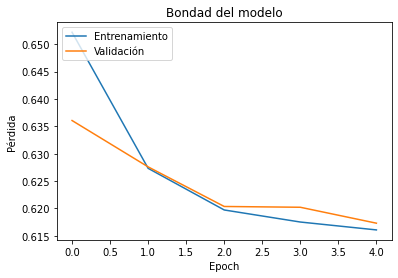

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_output.history["loss"])
plt.plot(train_output.history["val_loss"])
plt.title("Bondad del modelo")
plt.ylabel("Pérdida")
plt.xlabel("Epoch")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()


Con este modelo es sencillo poder componer una función encargada de obtener las películas no vistas con mejor puntuación para un usuario concreto.

In [ ]:
def nn_recommender(user_id, num=10):
  """
  Deberemos tener en cuenta la codificación antes empleada a la hora de entrenar el modelo
  """
  # Peliculas vistas
  seen_movies = ratings[ratings["user_id"] == user_id]

  # Películas no vistas
  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()
  not_seen = list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen = [[movie2movie_encoded.get(x)] for x in not_seen]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data para el modelo
  input_data  = np.hstack(([[encoded_id]] * len(not_seen), not_seen))
  pred_ratings = model.predict(input_data).flatten()

  # Top ratings
  top_rated = pred_ratings.argsort()[-num:][::-1]

  # Decode
  movie_id = [movie_encoded2movie.get(not_seen[x][0]) for x in top_rated]

  return movies[movies["movie_id"].isin(movie_id)]["title"]

In [ ]:
nn_recommender(196)

11               Usual Suspects, The (1995)
97         Silence of the Lambs, The (1991)
126                   Godfather, The (1972)
173          Raiders of the Lost Ark (1981)
177                     12 Angry Men (1957)
186          Godfather: Part II, The (1974)
190                          Amadeus (1984)
198    Bridge on the River Kwai, The (1957)
271                Good Will Hunting (1997)
482                       Casablanca (1942)
Name: title, dtype: object

In [ ]:
nn_recommender(5)

63                      Shawshank Redemption, The (1994)
284                                Secrets & Lies (1996)
301                             L.A. Confidential (1997)
312                                       Titanic (1997)
317                              Schindler's List (1993)
473    Dr. Strangelove or: How I Learned to Stop Worr...
478                                       Vertigo (1958)
479                            North by Northwest (1959)
482                                    Casablanca (1942)
602                                   Rear Window (1954)
Name: title, dtype: object

Para hacernos eco de los avances en este ámbito es muy recomendable la lectura del artículo [Deep Learning based Recommender System: A Survey and New Perspectives](https://arxiv.org/abs/1707.07435) de *Zhang et al* ya que da una visión amplia sobre las técnicas y avances al respecto de estas nuevas aproximaciones.

# Modelos basados en árboles

Los arboles de decisión han ganado adeptos también en problemas donde la categorización de elementos no es tan continua como desearíamos. Las redes neuronales funcionan muy bien cuando los datos entrentan cierta continuidad pero cuando nos enfrentamos a datos discretos o categóricos los arboles de decisión pueden mostrar una ventaja significativa.

## Codificación del contexto

Probaremos este hecho incluyendo información relativa a la ocupación y sexo de los usuarios de nuestro conjunto de datos de modo que esto ayude a refinar nuestras ponderaciones. Para ello podremos valernos de las funciones [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=onehot#sklearn.preprocessing.OneHotEncoder) y [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) de *sklearn*.

### Ejercicio

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

"""
Ejercicio: encontrar la forma de codificar la ocupación de nuestros usuarios 
como columnas on hot encoding y el sexo como un etiquetado
"""

# Obtengamos categorías de sexo y occupación para nuestros usuarios
occupation_cols = users["occupation"].unique().tolist()
ohe = OneHotEncoder()
users[occupation_cols] = ohe.fit_transform(users["occupation"].values.reshape(-1,1)).toarray()
users['sex'] = ohe.fit_transform(users["sex"].values.reshape(-1,1)).toarray()
# Obtengamos nuestro conjunto de datos de entrenamiento
x = ratings[['user_id', 'movie_id']]
y = ratings['rating']

selected_cols = occupation_cols + ["user_id", "age","sex"]
x = x.merge(users[selected_cols], on=["user_id","user_id"]).merge(movies[genre_cols + ["movie_id"]], on=["movie_id","movie_id"])
x

,user_id,movie_id,technician,other,writer,executive,administrator,student,lawyer,educator,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,305,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,6,242,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,234,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,63,242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,863,1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0
99996,863,1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99997,863,1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
99998,896,1681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Modelos ensemble

Tal y como vimos para las redes neuronales podemos emplear modelos concretos que exploten de manera distinta la información contextual disponible tanto de los usuarios como de los ítems. Y en este caso emplearemos un modelo ampliamente conocido en el mundo de la ciencia de datos: [XGBoost](https://xgboost.readthedocs.io/en/stable/#).

Este modelo se compone de conjuntos de árboles de decisión y podemos emplearlo nuevamente para obtener un rating esperado para aquellos casos en los que los datos no se encuentren disponibles (items no valorados).

Seleccionaremos el conjunto de datos a emplear en entrenamiento (90%) frente al de validación (10%).

In [ ]:
idx = int(0.9 * x.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

In [ ]:
import xgboost as xgb

# Configuramos el modelo en su versión de regressión
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
model_xgb.fit(x_train, y_train)

# Realizamos las prediciones sobre el conjunto de validación
pred = model_xgb.predict(x_val)
rmse = np.sqrt(np.mean((pred - y_val.to_numpy())**2))
print(f'RMSE sobre el rating basado en el contenido = {rmse}')

RMSE sobre el rating basado en el contenido = 1.1299110124868725


In [ ]:
def xgb_recommender(user_id, num=10):
  # Peliculas vistas
  seen_movies = ratings[ratings["user_id"] == user_id]

  # Películas no vistas
  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()

  # Ahora podemos refinar nuestra puntuación mediante el modelo XGBoost
  user_data = users[users["user_id"] == user_id][selected_cols]
  movie_data = movies[movies["movie_id"].isin(not_seen)][genre_cols + ["movie_id"]]

  # Obtengamos nuestro conjunto de datos de entrenamiento
  x_data = movie_data
  x_data["user_id"] = user_id
  x_data = x_data.merge(user_data, on=["user_id","user_id"])

  # Obtenemos las predicciones
  pred_xgb = model_xgb.predict(x_data[x.columns])
  ret_df = pd.DataFrame({"movie_id" : movie_data["movie_id"].values, "score" : pred_xgb})
  top_rated = ret_df.sort_values(by="score", ascending=False).head(num)["movie_id"].values.tolist()

  # Devolvemos la lista de las películas mejor valoradas
  return movies[movies["movie_id"].isin(top_rated)]["title"]

In [ ]:
xgb_recommender(196)

1231                   Madonna: Truth or Dare (1991)
1546                                Show, The (1995)
1560      Tigrero: A Film That Was Never Made (1994)
1561    Eye of Vichy, The (Oeil de Vichy, L') (1993)
1584                           American Dream (1990)
1593                                  Everest (1998)
1628                                Nico Icon (1995)
1640                                 Dadetown (1995)
1648                             Big One, The (1997)
1668                        MURDER and murder (1996)
Name: title, dtype: object

# Modelos híbridos

Los modelos híbridos pretenden beneficiarse de la disparidad que ofrecen los distintos modelos. Algunos más enfocados en capturar las similitudes entre usuarios, otros en capturar bien los potenciales feedbacks (ratings) entre pares usuario e ítem, ... Es una práctica habitual en el mundo de la ciencia de datos combinar modelos en modeladidades *bagging* o *boosting* de forma que la combinación entre distintos modelos nos ofrezca lo mejor de ambos.

Para una lectura extensa sobre la hibridación y su relevancia en el ámbito de los recomendadores tenéís el artículo de *Çano y Morisio* [Hybrid Recommender Systems: A Systematic Literature Review](https://arxiv.org/abs/1901.03888).

Nosotros podremos hacer una primera aproximación sencilla, simplemente empleando dos de los modelos previamente empleados. Existen multitud de opciones dentro de cómo combinar modelos. Bien sopesando de forma que podamos ponderar sus decisiones o simplemente promediando la decisión entre ambos modelos como veremos a continuación.

### Ejercicio

In [ ]:
def hybrid_recommender(user_id, num=10):
  """
  Ejercicio: combinar dos de los modelos anteriormente entrenados para poder así 
  combinar los resultados y mejorar nuestras predicciones. Puede ser una 
  combinación sencilla que simplemente pondere ambas puntuaciones.
  """
  # Peliculas vistas
  seen_movies = ratings[ratings["user_id"] == user_id]

  # Películas no vistas
  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()
  not_seen = list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen = [[movie2movie_encoded.get(x)] for x in not_seen]

  # User
  encoded_id = user2user_encoded.get(user_id)

  # Input data para el modelo
  input_data  = np.hstack(([[encoded_id]] * len(not_seen), not_seen))
  pred_ratings = model.predict(input_data).flatten()

  # Top ratings
  top_rated = pred_ratings.argsort()[-num:][::-1]
  movie_id = [movie_encoded2movie.get(not_seen[x][0]) for x in top_rated]

  # Ahora podemos refinar nuestra puntuación mediante el modelo XGBoost
  user_data = users[users["user_id"] == user_id][selected_cols]
  movie_data = movies[movies["movie_id"].isin(not_seen)][genre_cols + ["movie_id"]]

  # # Obtengamos nuestro conjunto de datos de entrenamiento
  x_data = movie_data
  x_data["user_id"] = user_id
  x_data = x_data.merge(user_data, on=["user_id","user_id"])

  # # Obtenemos las predicciones
  pred_xgb = model_xgb.predict(x_data[x.columns])
  ret_df = pd.DataFrame({"movie_id" : movie_data["movie_id"].values, "score" : pred_xgb})
  #top_rated = ret_df.sort_values(by="score", ascending=False).head(num)["movie_id"].values.tolist()


  ...

  # Devolvemos la lista de las películas mejor valoradas
  return movies[movies["movie_id"].isin(top_rated)]["title"]

In [ ]:
hybrid_recommender(196)

9                                   Richard III (1995)
89                 So I Married an Axe Murderer (1993)
114    Haunted World of Edward D. Wood Jr., The (1995)
159                         Glengarry Glen Ross (1992)
163                                  Abyss, The (1989)
172                         Princess Bride, The (1987)
176             Good, The Bad and The Ugly, The (1966)
184                                      Psycho (1960)
251              Lost World: Jurassic Park, The (1997)
452                                    Jaws 3-D (1983)
Name: title, dtype: object

In [ ]:
hybrid_recommender(5)

50       Legends of the Fall (1994)
203       Back to the Future (1985)
220       Breaking the Waves (1996)
231               Young Guns (1988)
236            Jerry Maguire (1996)
297                 Face/Off (1997)
302              Ulee's Gold (1997)
303            Fly Away Home (1996)
306    Devil's Advocate, The (1997)
426    To Kill a Mockingbird (1962)
Name: title, dtype: object